In [1]:
import sys
sys.path.append("..")

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import SpectralEmbedding, TSNE, MDS
import torch
import umap
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [64]:
df = pd.read_csv("extracted_flame_front_120.csv")

# Select meaningful physical variables
#features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]
# features = ['u', 'v', 'T', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#        'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
#        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
#        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
#        'flow_velocity_tangential', 'tangential_strain_rate',
#        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
#        'vorticity', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O',
#        'omega_OH', 'omega_HO2', 'omega_H2O2', 'omega_N2', 'Le_def']
features = [
    'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
    'omega_HO2', 'omega_H2O2', 'omega_N2', 'T'
]

#features = ['T','H2','O2', 'H2O', 'HO2', 'H2O2']

colourmap = df["disp_speed_density_weighted"]

X = StandardScaler().fit_transform(df[features])


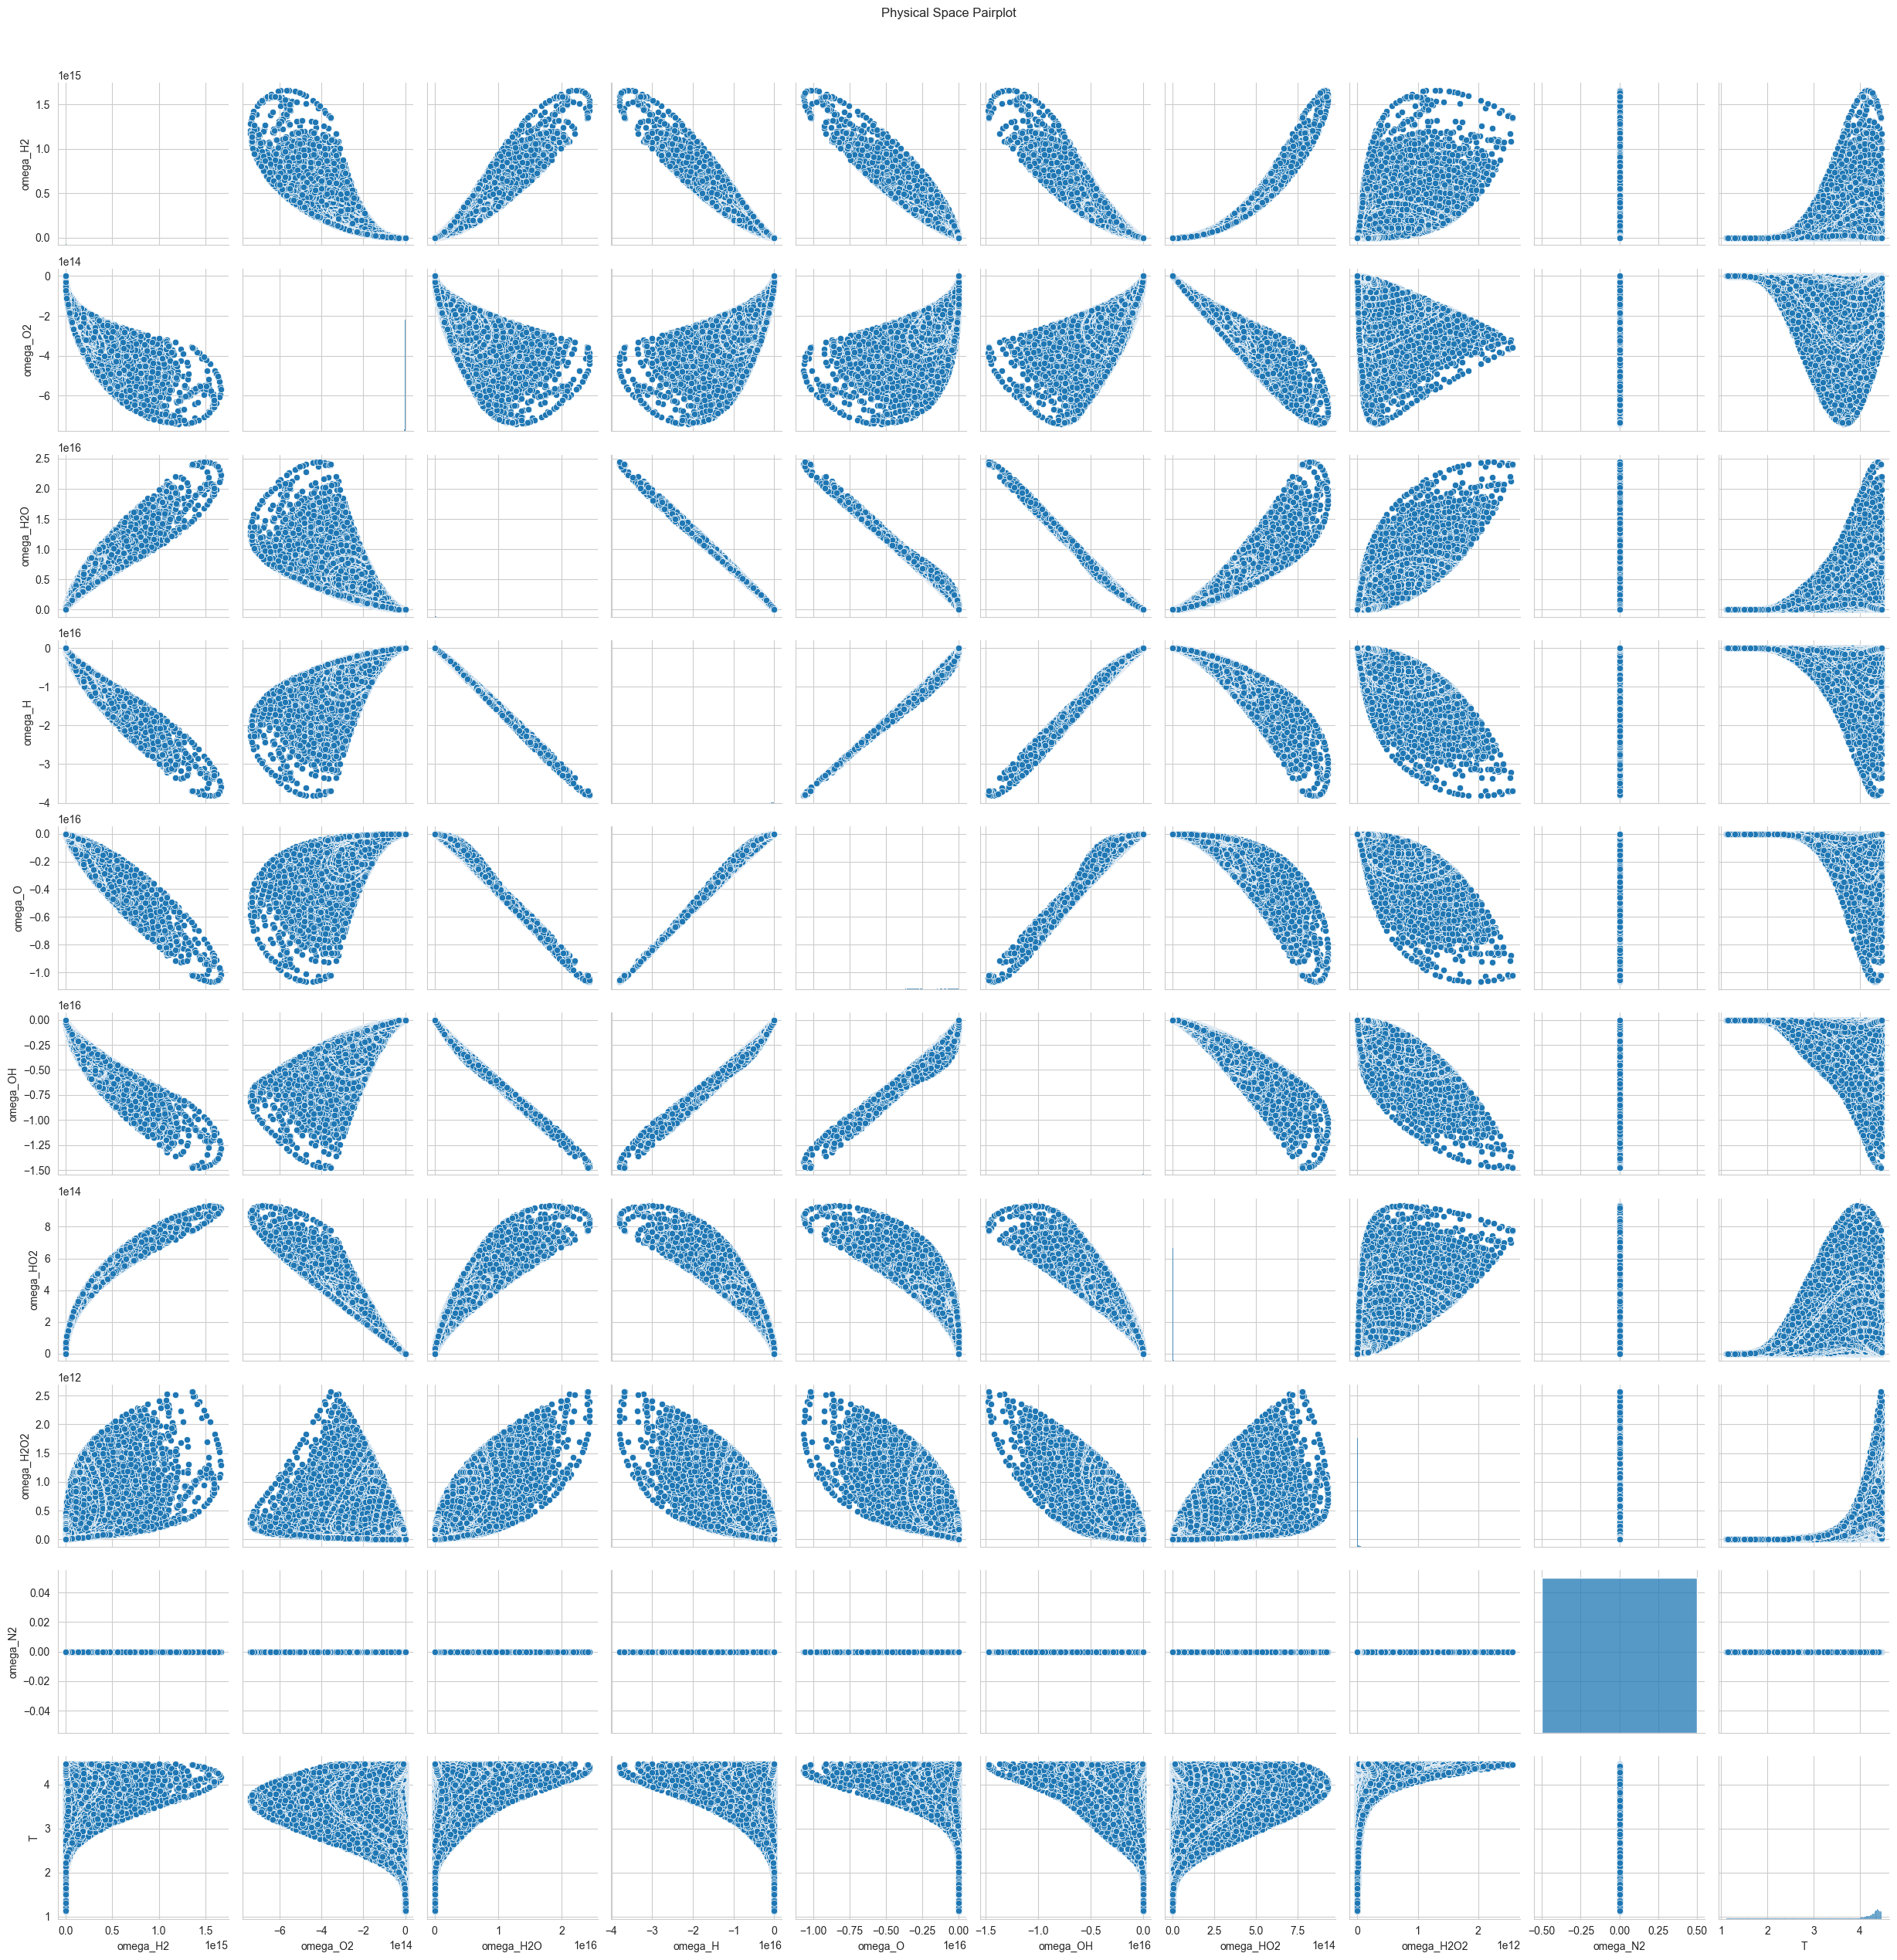

In [65]:
sns.pairplot(df[features])
plt.suptitle('Physical Space Pairplot', y=1.02)
plt.show()

## UMAP

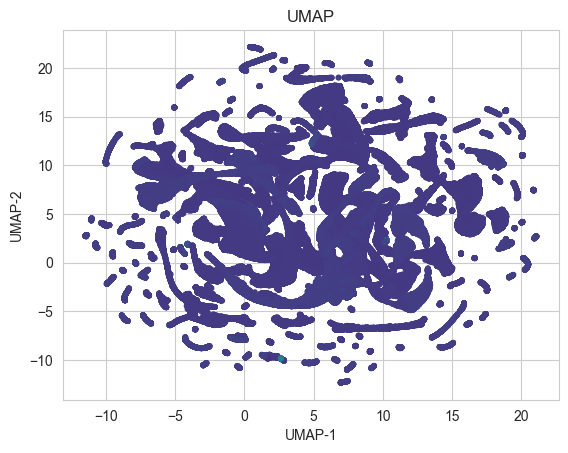

In [66]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=100, n_components=2 ,init ="random")
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## UMAP -> HDBSCAN -> MI -> Mapping to original space
Taken from "Identifying key features in reactive flows: A tutorial on combining
dimensionality reduction, unsupervised clustering, and feature correlation"

348


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster summary: {np.int64(-1): np.int64(46868), np.int64(0): np.int64(1330), np.int64(1): np.int64(1177), np.int64(2): np.int64(1232), np.int64(3): np.int64(4713), np.int64(4): np.int64(1283), np.int64(5): np.int64(1769), np.int64(6): np.int64(1607), np.int64(7): np.int64(3902), np.int64(8): np.int64(1300), np.int64(9): np.int64(1402), np.int64(10): np.int64(1252), np.int64(11): np.int64(8452), np.int64(12): np.int64(1033), np.int64(13): np.int64(3252), np.int64(14): np.int64(2386), np.int64(15): np.int64(4084), np.int64(16): np.int64(2321), np.int64(17): np.int64(11077), np.int64(18): np.int64(3841), np.int64(19): np.int64(5620), np.int64(20): np.int64(1538), np.int64(21): np.int64(2720), np.int64(22): np.int64(1608), np.int64(23): np.int64(1672), np.int64(24): np.int64(1270), np.int64(25): np.int64(2450)}
Number of clusters (excluding noise): 26
Noise fraction: 0.386830528479106
Average cluster probability: 0.962023210315306


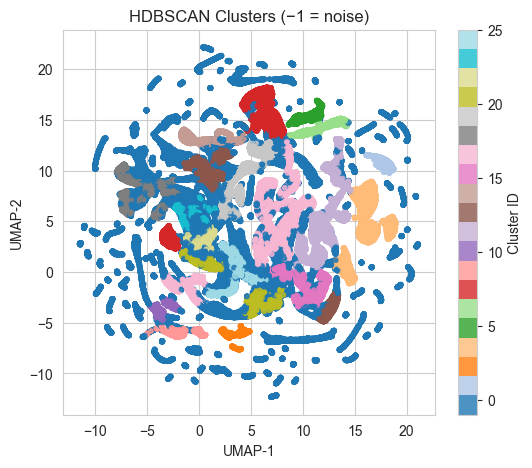

In [89]:
# ============================================================
# HDBSCAN CLUSTERING
# ============================================================

print(int(np.sqrt(len(X))))
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=1000, #int(np.sqrt(len(X))),
    min_samples= 250, #int(np.sqrt(len(X))), #int(np.sqrt(len(X))),
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
).fit(X_embedded)

labels = clusterer.labels_
proba  = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)

# ============================================================
# UMAP SPACE PLOT
# ============================================================
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=labels, cmap='tab20', s=10, alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


Global mutual information ranking:
      feature   MI_dim1   MI_dim2    MI_sum
9           T  3.261406  3.172029  6.433435
7  omega_H2O2  1.112983  0.992729  2.105712
6   omega_HO2  0.972527  0.909933  1.882460
1    omega_O2  0.972009  0.859437  1.831445
3     omega_H  0.808944  0.791051  1.599995
2   omega_H2O  0.788889  0.745725  1.534614
5    omega_OH  0.797824  0.731638  1.529461
4     omega_O  0.655115  0.662098  1.317214
0    omega_H2  0.630541  0.643045  1.273586
8    omega_N2  0.001411  0.001750  0.003161


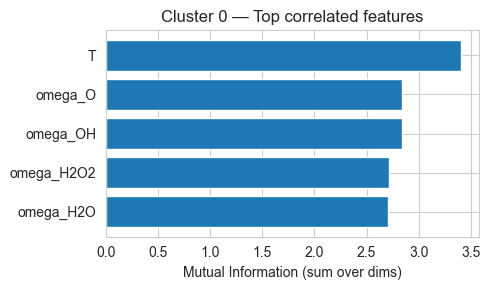

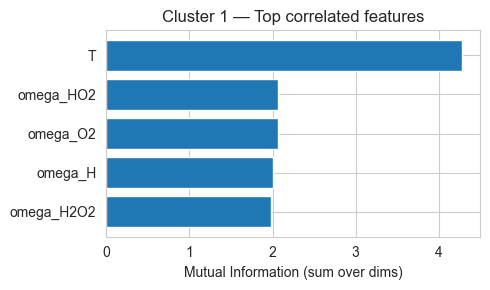

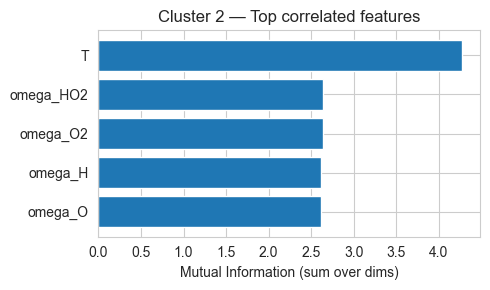

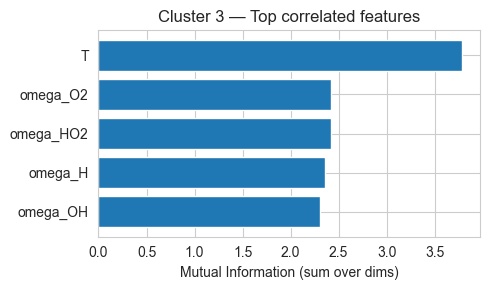

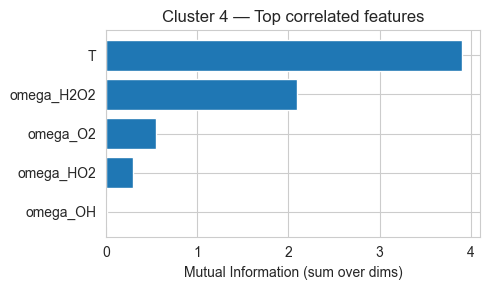

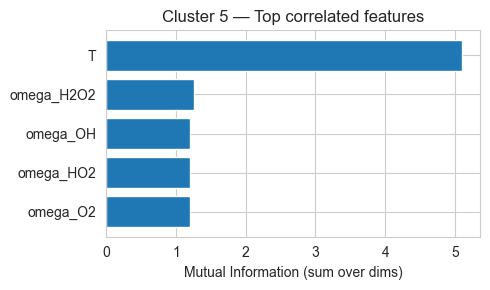

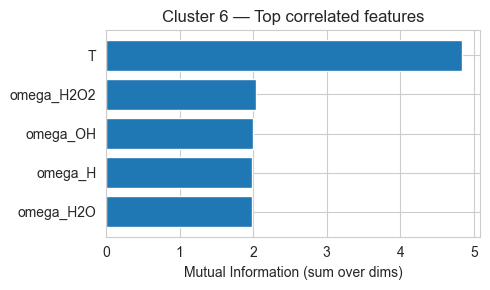

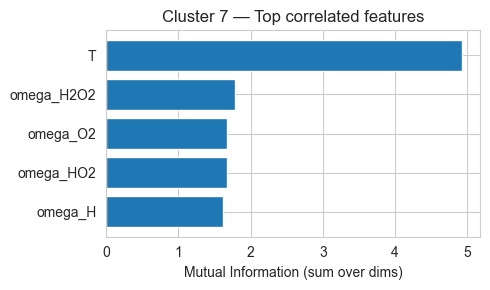

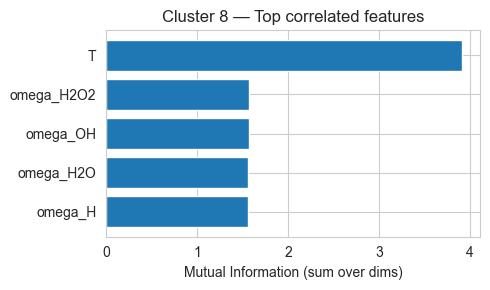

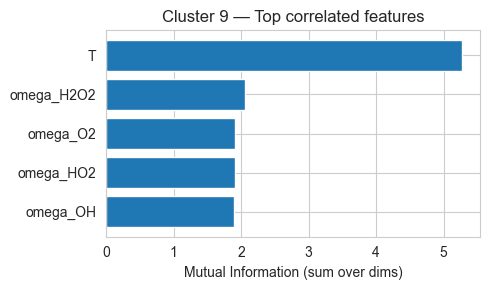

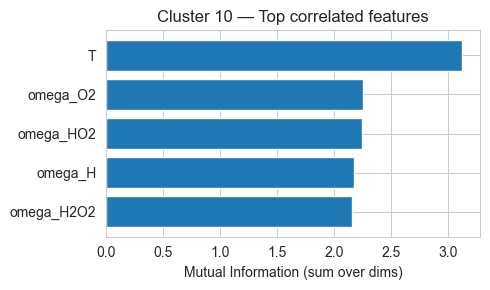

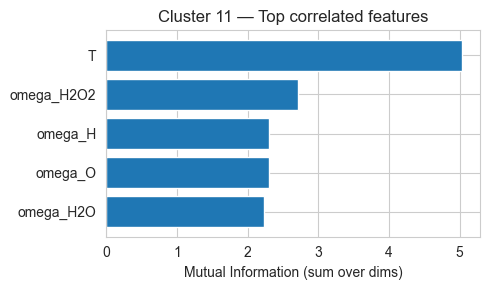

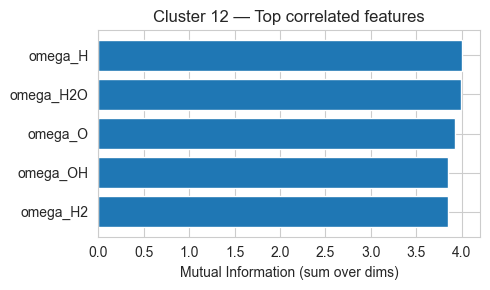

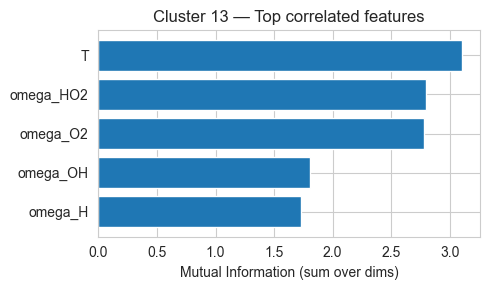

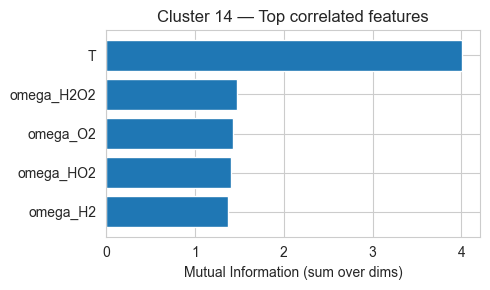

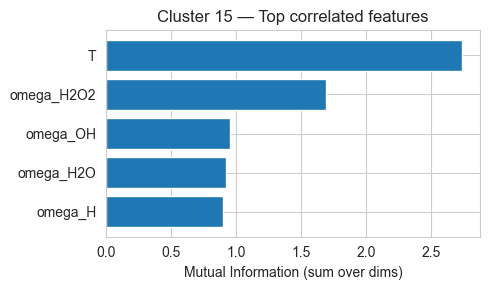

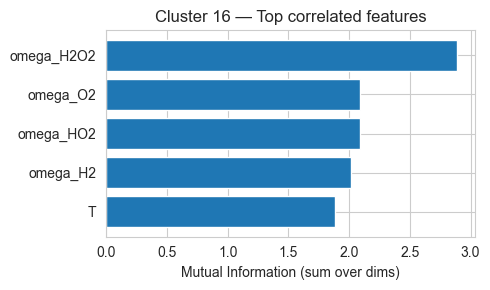

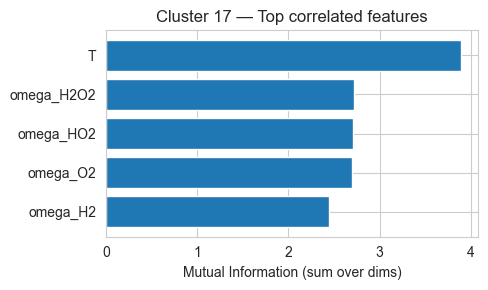

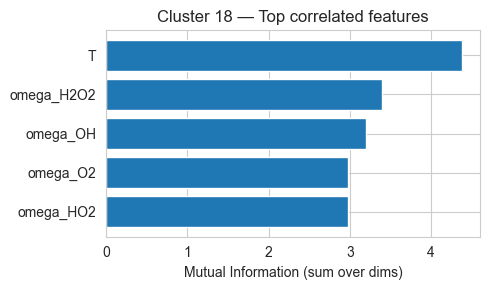

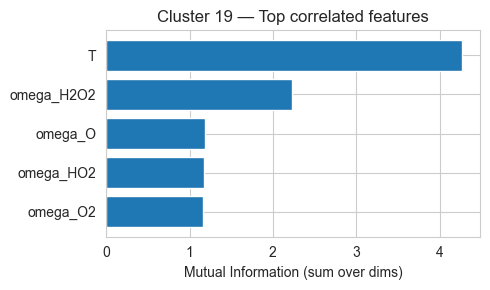

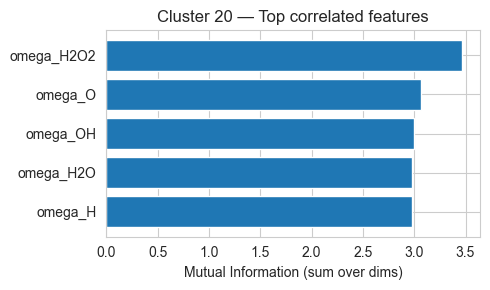

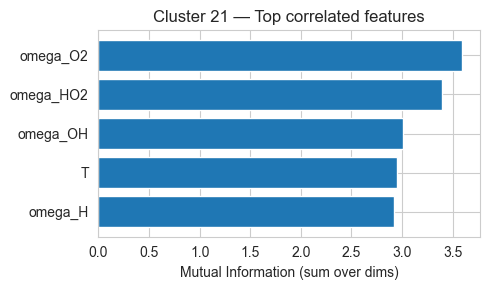

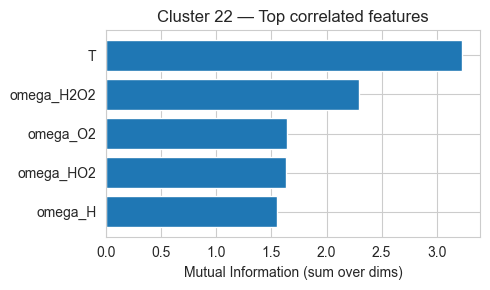

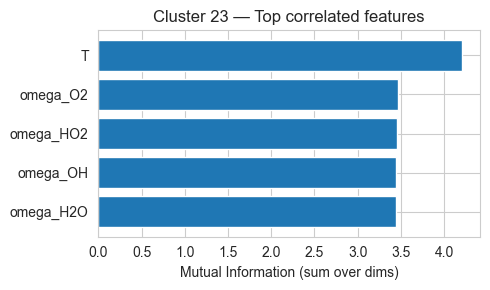

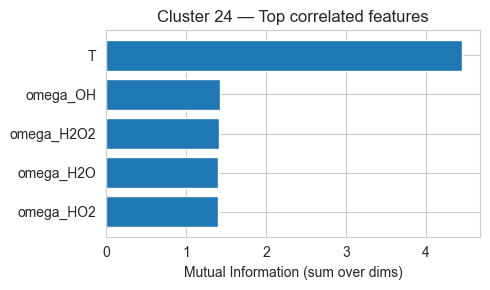

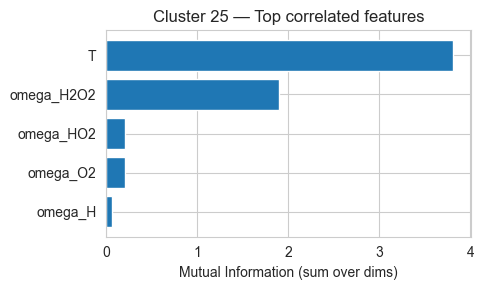

In [90]:

# ============================================================
# GLOBAL MUTUAL INFORMATION
# ============================================================
from sklearn.feature_selection import mutual_info_regression

mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))
# ============================================================
# PER-CLUSTER MUTUAL INFORMATION
# ============================================================
cluster_labels = sorted(set(labels) - {-1})
mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:
        continue

    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)

    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)

    mi_cluster[cluster] = df_new


# Plot top correlations
for cluster, df_new in mi_cluster.items():
    top = df_new.head(5)
    plt.figure(figsize=(5,3))
    plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
    plt.xlabel("Mutual Information (sum over dims)")
    plt.title(f"Cluster {cluster} — Top correlated features")
    plt.tight_layout()
    plt.show()



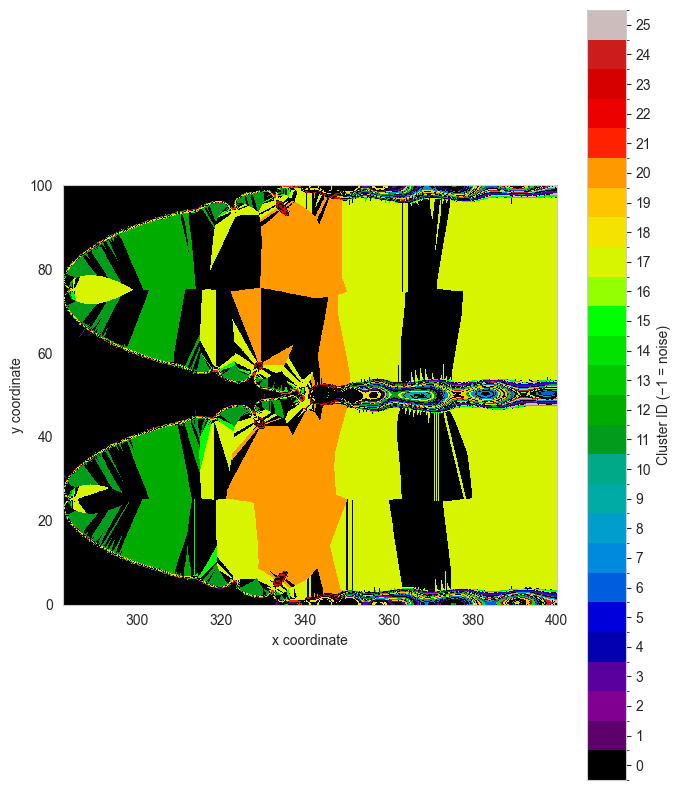

             omega_H2      omega_O2     omega_H2O       omega_H       omega_O  \
cluster                                                                         
-1       3.179766e+13 -3.543905e+13  5.820566e+14 -8.860930e+14 -2.137319e+14   
 0       5.816962e+07 -2.443036e+11  4.267843e+10 -2.890409e+11 -1.665839e+09   
 1       1.732192e+10 -3.233138e+12  1.880666e+12 -5.191579e+12 -4.043724e+10   
 2      -9.314580e+05 -9.714780e+09  7.094995e+09 -1.711874e+10 -5.304675e+08   
 3      -4.595387e+06 -1.659587e+10  1.781906e+10 -3.530965e+10 -1.394132e+09   

             omega_OH     omega_HO2    omega_H2O2  omega_N2         T  
cluster                                                                
-1      -3.858944e+14  4.416897e+13  5.496465e+10       0.0  3.540422  
 0      -4.208338e+10  2.440269e+11  8.120902e+08       0.0  3.529778  
 1      -1.837268e+12  3.230444e+12  1.213313e+09       0.0  1.801045  
 2      -9.479109e+09  9.934416e+09  1.237655e+09       0.0  4.266863  


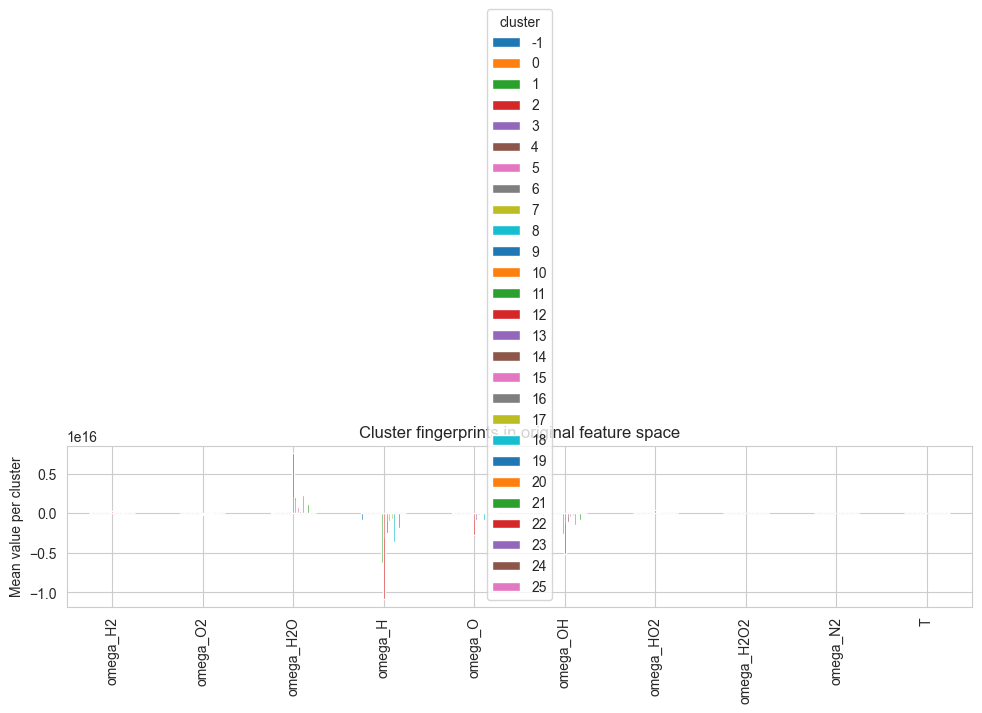

In [91]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
import matplotlib
from scipy.interpolate import griddata

# Resolution of structured grid
nx, ny = 1000, 1000

# Automatically use full domain of your flame-front slice
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()

grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, nx),
    np.linspace(y_min, y_max, ny)
)

# Interpolate cluster labels to grid
z_structured = griddata(
    (df['x'], df['y']),
    labels,
    (grid_x, grid_y),
    method='nearest'
)

bounds = np.arange(-0.5, labels.max() + 1.5, 1)
cmap = matplotlib.colormaps['nipy_spectral']
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(7,8))
plt.pcolormesh(
    grid_x, grid_y, z_structured,
    cmap=cmap,
    norm=norm,
    shading='nearest'
)

cb = plt.colorbar(ticks=np.arange(labels.min(), labels.max()+1))
cb.set_label("Cluster ID (−1 = noise)")

plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# ============================================================
# STATISTICS + FINGERPRINTS
# ============================================================
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()

print(cluster_means.head())

cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()


## Spectral Embedding

In [73]:
SE = SpectralEmbedding(n_components=2, n_neighbors=30)
X_SE = SE.fit_transform(X)
# Plot
plt.scatter(X_SE[:,0], X_SE[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("Spectral Embedding")
plt.xlabel("SE-1")
plt.ylabel("SE-2")
plt.show()

KeyboardInterrupt: 

## t-SNE

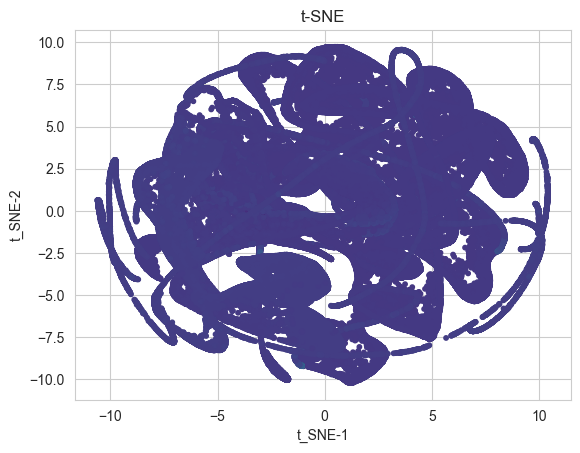

In [92]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)
X_sne = t_sne.fit_transform(X)

plt.scatter(X_sne[:,0], X_sne[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("t-SNE")
plt.xlabel("t_SNE-1")
plt.ylabel("t_SNE-2")
plt.show()


## Multidimensional Scaling

In [30]:
mds_embedding = MDS(n_components=2, n_init=1)
X_mds = mds_embedding.fit_transform(X)

plt.scatter(X_mds[:,0], X_mds[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("MDS")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.show()


KeyboardInterrupt: 

## PCA: Chemichal State vs Reaction rates

[State-space features (φ)] Centroids in original feature units:
 [[ 7.28094397e-06  1.53645719e-01  8.93481298e-02  1.82874867e-07
   1.15606652e-05  7.30594950e-05  1.76154073e-06  5.88105010e-07]
 [ 4.32797259e-03  2.08513533e-01  3.16754629e-02  1.79523657e-06
   9.34252145e-06  2.57644135e-05  1.92470136e-04  6.45368988e-05]
 [ 1.18127877e-03  1.60416899e-01  8.10421876e-02  4.16946141e-05
   6.34529301e-04  6.30446790e-04  7.53341388e-05  6.47204123e-06]
 [ 2.24862882e-03  1.83290625e-01  5.96041790e-02  1.76064958e-05
   1.69277999e-04  1.78468048e-04  1.45133782e-04  2.52330867e-05]
 [ 7.11850698e-03  2.26042571e-01  8.39688138e-03 -1.06153902e-08
  -5.56680024e-08 -3.17103466e-08  3.72443762e-05  3.16792660e-05]
 [ 6.43626373e-04  1.45147326e-01  9.44455412e-02  6.49789030e-05
   1.15636331e-03  1.28643388e-03  4.98237384e-05  5.56000854e-06]]

[State-space features (φ)] Explained variance ratio per component:
  PC 1:  0.5285   (cumulative:  0.5285)
  PC 2:  0.3694   (cumulativ

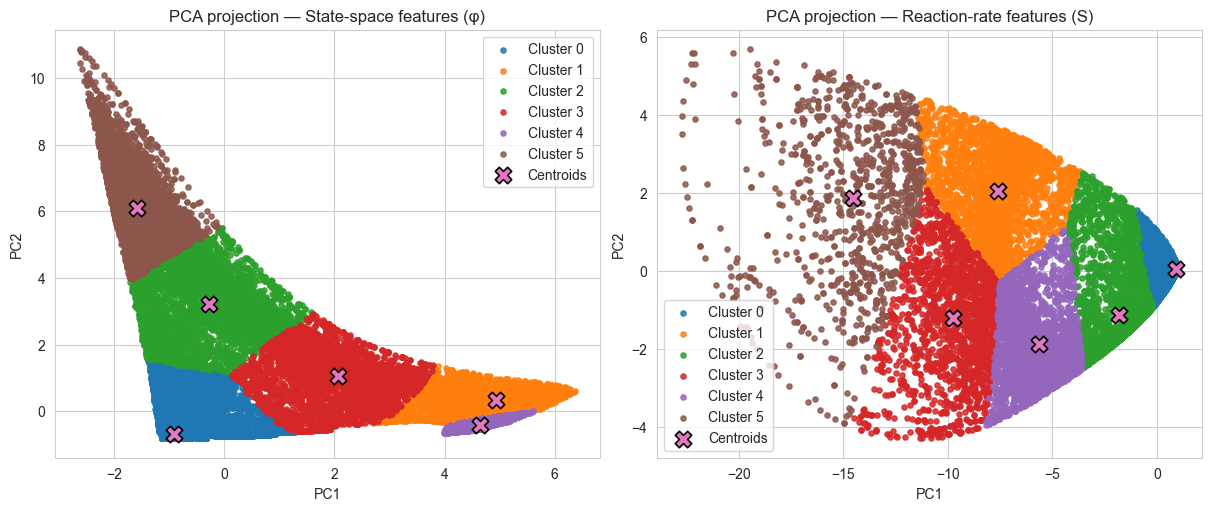

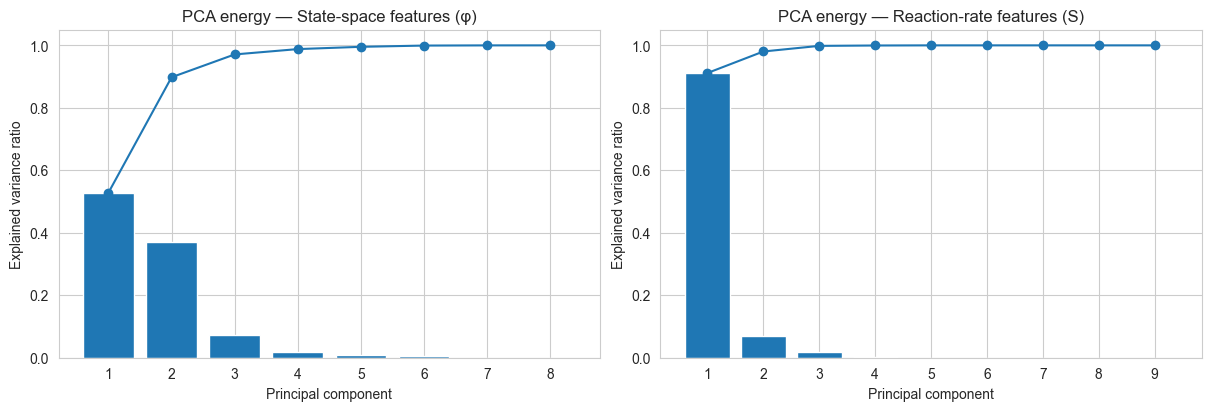

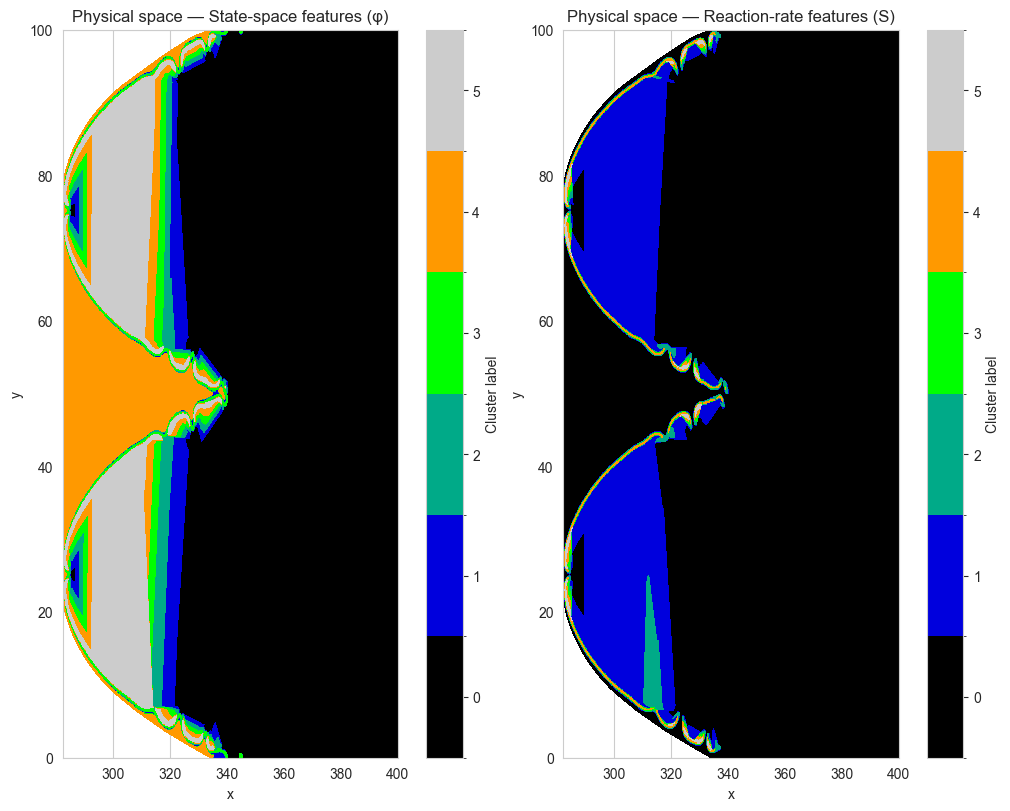

In [46]:
from sklearn.decomposition import PCA
# --- Pre-create side-by-side figures (left=state features, right=rate features) ---
fig_pca,   axs_pca   = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
fig_scree, axs_scree = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig_phys,  axs_phys  = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

col_titles = {0: "State-space features (φ)", 1: "Reaction-rate features (S)"}

import matplotlib.tri as mtri
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mat

# Triangulation of fixed physical coordinates (reuse for both feature settings)
tri = mtri.Triangulation(df['x'].to_numpy(), df['y'].to_numpy())

for feature_setting in range(2):
    if feature_setting == 0:
        features = [
            'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2'
        ]
    else:
        features = [
            'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
            'omega_HO2', 'omega_H2O2', 'omega_N2'
        ]

    X_raw = df[features].to_numpy()
    k = 6
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=k, init="k-means++", n_init="auto", max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    # Pull out scaler and centroids (centroids are in scaled space)
    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled   = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    print(f"[{col_titles[feature_setting]}] Centroids in original feature units:\n", centroids_unscaled)

    # Optional: quality metric
    X_scaled = scaler.transform(X_raw)

    # ===== PCA for visualization (fit on scaled data seen by KMeans) =====
    pca = PCA(n_components=None, random_state=0)
    X2d        = pca.fit_transform(X_scaled)            # (n, >=2)
    centroids2d = pca.transform(centroids_scaled)       # centroids in scaled space

    evr     = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    print(f"\n[{col_titles[feature_setting]}] Explained variance ratio per component:")
    for i, (e, c) in enumerate(zip(evr, cum_evr), start=1):
        print(f"  PC{i:>2}: {e:7.4f}   (cumulative: {c:7.4f})")

    # ===== Plot A: PCA clusters (side-by-side) =====
    axp = axs_pca[feature_setting]
    for c in range(k):
        axp.scatter(
            X2d[labels == c, 0], X2d[labels == c, 1],
            s=14, alpha=0.85, label=f"Cluster {c}"
        )
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        s=140, marker="X", edgecolor="k", linewidths=1.2, label="Centroids"
    )
    axp.set_title(f"PCA projection — {col_titles[feature_setting]}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")
    axp.legend(loc="best")

    # ===== Plot B: Scree (side-by-side) =====
    axs = axs_scree[feature_setting]
    idx = np.arange(1, len(evr) + 1)
    axs.bar(idx, evr)
    axs.plot(idx, cum_evr, marker="o")
    axs.set_title(f"PCA energy — {col_titles[feature_setting]}")
    axs.set_xlabel("Principal component")
    axs.set_ylabel("Explained variance ratio")
    axs.set_xticks(idx)

    # ===== Plot C: Physical x–y map (side-by-side) — continuous categorical fill =====
    # --- choose a categorical colormap with exactly k distinct colors ---
    cmap = mat.colormaps.get_cmap('nipy_spectral')
    # --- discrete boundaries so each integer label maps to one color band ---
    bounds = np.arange(-0.5, k + 0.5, 1)
    norm   = BoundaryNorm(bounds, cmap.N)

    z = labels  # cluster labels (length n)

    # >>>>> THIS IS THE IMPORTANT CHANGE <<<<<
    ax_phys = axs_phys[feature_setting]  # use pre-created axis instead of new figure

    # Option 1: use triangulation (slightly cleaner)
    c = ax_phys.tricontourf(tri, z, levels=bounds, cmap=cmap, norm=norm)

    # Attach colorbar to fig_phys, but only for this axis
    cb = fig_phys.colorbar(c, ax=ax_phys, ticks=np.arange(k))
    cb.set_label("Cluster label")

    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")

    ax_phys.set_title(f"Physical space — {col_titles[feature_setting]}")

# --- Render all figures once, side-by-side comparisons ready ---
plt.show()
